In [7]:
#all imports

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms, models
from torchmetrics import ConfusionMatrix, Accuracy, Precision, Recall, F1Score

from torch.nn import BCELoss
from torch.autograd import Variable

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import numpy as np
import pickle

In [8]:
#GPU and CPU related

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [9]:
data_dir = '/kaggle/input/plantdisease/PlantVillage'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)

In [10]:
pepper_classes = [
    'Pepper__bell___Bacterial_spot',
    'Pepper__bell___healthy'
]

potato_classes = [
    'Potato___Early_blight',
    'Potato___Late_blight',
    'Potato___healthy'
]

tomato_classes = [
    'Tomato_Bacterial_spot',
    'Tomato_Early_blight',
    'Tomato_Late_blight',
    'Tomato_Leaf_Mold',
    'Tomato_Septoria_leaf_spot',
    'Tomato_Spider_mites_Two_spotted_spider_mite',
    'Tomato__Target_Spot',
    'Tomato__Tomato_YellowLeaf__Curl_Virus',
    'Tomato__Tomato_mosaic_virus',
    'Tomato_healthy'
]
all_classes = pepper_classes + potato_classes + tomato_classes

class_counts = {cls: 0 for cls in all_classes}

for path, label in dataset.samples:
    class_name = dataset.classes[label]
    if class_name in all_classes:
        class_counts[class_name] += 1

print("\nFull Dataset Summary:")
for class_name, count in class_counts.items():
    print(f"Class '{class_name}': {count} images")


Full Dataset Summary:
Class 'Pepper__bell___Bacterial_spot': 997 images
Class 'Pepper__bell___healthy': 1478 images
Class 'Potato___Early_blight': 1000 images
Class 'Potato___Late_blight': 1000 images
Class 'Potato___healthy': 152 images
Class 'Tomato_Bacterial_spot': 2127 images
Class 'Tomato_Early_blight': 1000 images
Class 'Tomato_Late_blight': 1909 images
Class 'Tomato_Leaf_Mold': 952 images
Class 'Tomato_Septoria_leaf_spot': 1771 images
Class 'Tomato_Spider_mites_Two_spotted_spider_mite': 1676 images
Class 'Tomato__Target_Spot': 1404 images
Class 'Tomato__Tomato_YellowLeaf__Curl_Virus': 3208 images
Class 'Tomato__Tomato_mosaic_virus': 373 images
Class 'Tomato_healthy': 1591 images


In [11]:
print("Pepper Classes and Counts:")
for class_name in pepper_classes:
    print(f"Class '{class_name}': {class_counts[class_name]} images")

print("\nPotato Classes and Counts:")
for class_name in potato_classes:
    print(f"Class '{class_name}': {class_counts[class_name]} images")

print("\nTomato Classes and Counts:")
for class_name in tomato_classes:
    print(f"Class '{class_name}': {class_counts[class_name]} images")

Pepper Classes and Counts:
Class 'Pepper__bell___Bacterial_spot': 997 images
Class 'Pepper__bell___healthy': 1478 images

Potato Classes and Counts:
Class 'Potato___Early_blight': 1000 images
Class 'Potato___Late_blight': 1000 images
Class 'Potato___healthy': 152 images

Tomato Classes and Counts:
Class 'Tomato_Bacterial_spot': 2127 images
Class 'Tomato_Early_blight': 1000 images
Class 'Tomato_Late_blight': 1909 images
Class 'Tomato_Leaf_Mold': 952 images
Class 'Tomato_Septoria_leaf_spot': 1771 images
Class 'Tomato_Spider_mites_Two_spotted_spider_mite': 1676 images
Class 'Tomato__Target_Spot': 1404 images
Class 'Tomato__Tomato_YellowLeaf__Curl_Virus': 3208 images
Class 'Tomato__Tomato_mosaic_virus': 373 images
Class 'Tomato_healthy': 1591 images


In [13]:
from collections import Counter
import random
# from PIL import Image

augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class_counts = Counter([label for _, label in dataset.samples])
min_samples = min(class_counts.values())
augmented_samples = []
augmented_labels = []

for class_idx, class_name in enumerate(dataset.classes):
    class_images = [(path, label) for path, label in dataset.samples if label == class_idx]
    current_count = class_counts[class_idx]
    
    if current_count < 400:
        target_samples = int(current_count * 1.3)
        extra_samples_needed = target_samples - current_count
        
        for _ in range(extra_samples_needed):
            sample = random.choice(class_images)
            augmented_samples.append(sample[0])
            augmented_labels.append(sample[1])

for path, label in zip(augmented_samples, augmented_labels):
    dataset.samples.append((path, label))

augmented_class_counts = Counter([label for _, label in dataset.samples])
print("\nAugmented Dataset Summary:")
for class_name, count in zip(dataset.classes, augmented_class_counts.values()):
    print(f"Class '{class_name}': {count} images")



Augmented Dataset Summary:
Class 'Pepper__bell___Bacterial_spot': 997 images
Class 'Pepper__bell___healthy': 1478 images
Class 'Potato___Early_blight': 1000 images
Class 'Potato___Late_blight': 1000 images
Class 'Potato___healthy': 197 images
Class 'Tomato_Bacterial_spot': 2127 images
Class 'Tomato_Early_blight': 1000 images
Class 'Tomato_Late_blight': 1909 images
Class 'Tomato_Leaf_Mold': 952 images
Class 'Tomato_Septoria_leaf_spot': 1771 images
Class 'Tomato_Spider_mites_Two_spotted_spider_mite': 1676 images
Class 'Tomato__Target_Spot': 1404 images
Class 'Tomato__Tomato_YellowLeaf__Curl_Virus': 3208 images
Class 'Tomato__Tomato_mosaic_virus': 484 images
Class 'Tomato_healthy': 1591 images


In [14]:
from torch.utils.data import DataLoader, random_split
from torchvision import models
import torch.nn as nn
import torch.optim as optim

train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [15]:
model = models.resnet50(pretrained=True)

# Modify the final fully connected layer for the specific number of classes
num_classes = len(dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

# Save the trained model
model_save_path = "aug_res50_model.pth"
torch.save(model.state_dict(), model_save_path)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 219MB/s]


Epoch 1/10, Loss: 0.4850
Epoch 2/10, Loss: 0.2192
Epoch 3/10, Loss: 0.1460
Epoch 4/10, Loss: 0.1195
Epoch 5/10, Loss: 0.0944
Epoch 6/10, Loss: 0.0813
Epoch 7/10, Loss: 0.0728
Epoch 9/10, Loss: 0.0510
Epoch 10/10, Loss: 0.0541


In [16]:
import torch.nn.functional as F
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

model.load_state_dict(torch.load("aug_res50_model.pth"))
model.to(device)

model.eval()

val_loss = 0.0
correct_val = 0
total_val = 0
y_true_val = []
y_pred_val = []

# Evaluate on validation data for tuning
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        

        loss = F.cross_entropy(outputs, labels)
        val_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_val += (predicted == labels).sum().item()
        total_val += labels.size(0)

        y_true_val.extend(labels.cpu().numpy())
        y_pred_val.extend(predicted.cpu().numpy())

avg_val_loss = val_loss / len(val_loader)
val_accuracy = 100 * correct_val / total_val

print(f"Validation Loss: {avg_val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.2f}%")

print("\nClassification Report on Validation Set:")
print(classification_report(y_true_val, y_pred_val, target_names=dataset.classes))

/tmp/ipykernel_23/398640943.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("aug_res50_model.pth"))


Validation Loss: 0.2441
Validation Accuracy: 93.17%

Classification Report on Validation Set:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.98      0.98      0.98       105
                     Pepper__bell___healthy       0.99      0.99      0.99       140
                      Potato___Early_blight       0.81      1.00      0.89        96
                       Potato___Late_blight       1.00      0.97      0.98        95
                           Potato___healthy       1.00      0.96      0.98        24
                      Tomato_Bacterial_spot       0.95      0.91      0.93       218
                        Tomato_Early_blight       0.78      0.93      0.84       120
                         Tomato_Late_blight       0.98      0.91      0.94       159
                           Tomato_Leaf_Mold       0.94      0.92      0.93       102
                  Tomato_Septoria_leaf_spot       1.00 

In [17]:
# Evaluate on the test set
y_true_test = []
y_pred_test = []
test_loss = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        
        loss = F.cross_entropy(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_test += (predicted == labels).sum().item()
        total_test += labels.size(0)

        y_true_test.extend(labels.cpu().numpy())
        y_pred_test.extend(predicted.cpu().numpy())

avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct_test / total_test

print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")

print("\nClassification Report on Test Set:")
print(classification_report(y_true_test, y_pred_test, target_names=dataset.classes))

conf_matrix_test = confusion_matrix(y_true_test, y_pred_test)
print("Confusion Matrix for Test Set:")
print(conf_matrix_test)

Test Loss: 0.2377
Test Accuracy: 93.61%

Classification Report on Test Set:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.99      0.99      0.99       111
                     Pepper__bell___healthy       1.00      0.99      0.99       134
                      Potato___Early_blight       0.85      1.00      0.92        92
                       Potato___Late_blight       0.99      0.97      0.98        99
                           Potato___healthy       1.00      0.89      0.94        19
                      Tomato_Bacterial_spot       0.97      0.92      0.94       223
                        Tomato_Early_blight       0.76      0.94      0.84        93
                         Tomato_Late_blight       0.96      0.92      0.94       199
                           Tomato_Leaf_Mold       0.97      0.90      0.93        93
                  Tomato_Septoria_leaf_spot       1.00      0.68      0.8

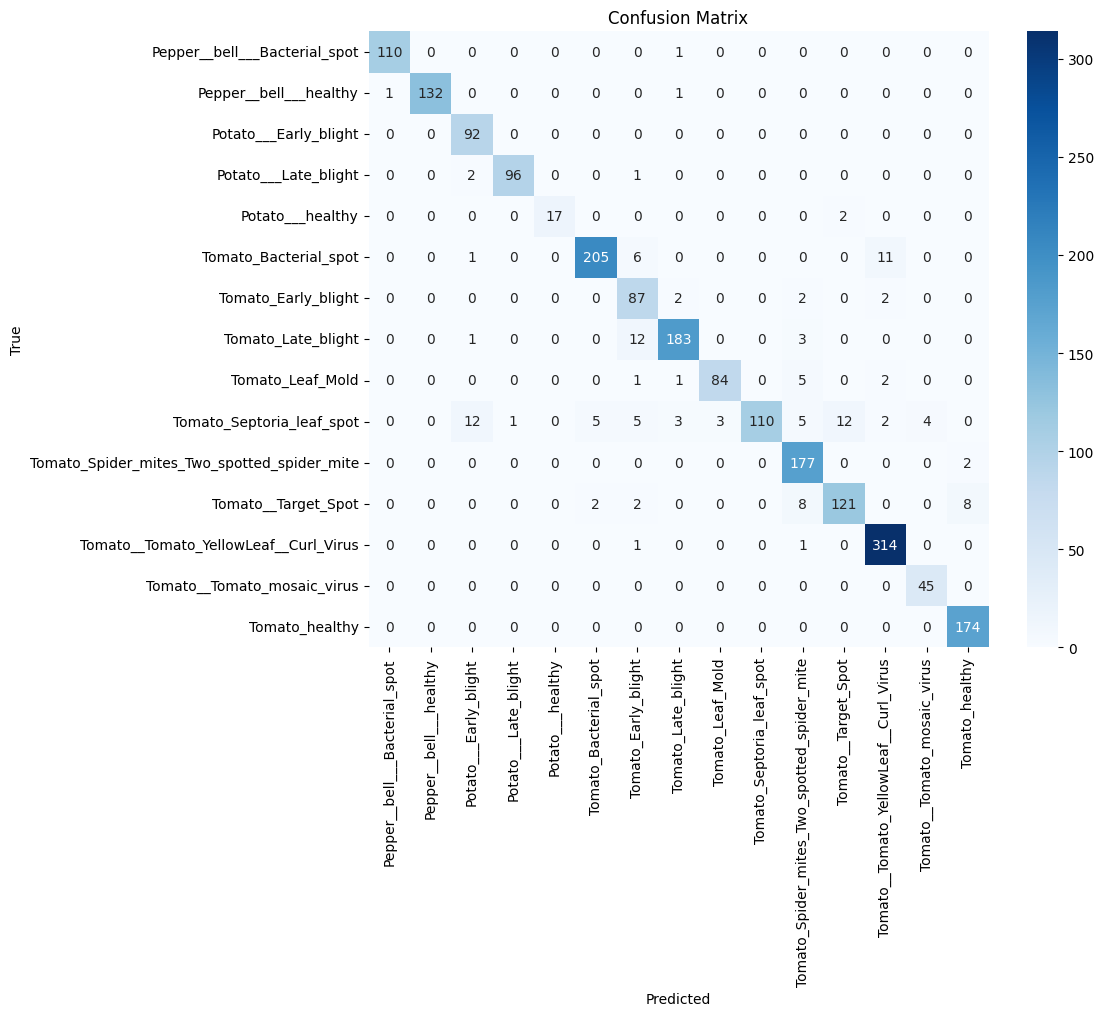

In [18]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# MobileNetV2

In [19]:
print("\nAugmented Dataset Summary:")
for class_name, count in zip(dataset.classes, augmented_class_counts.values()):
    print(f"Class '{class_name}': {count} images")


Augmented Dataset Summary:
Class 'Pepper__bell___Bacterial_spot': 997 images
Class 'Pepper__bell___healthy': 1478 images
Class 'Potato___Early_blight': 1000 images
Class 'Potato___Late_blight': 1000 images
Class 'Potato___healthy': 197 images
Class 'Tomato_Bacterial_spot': 2127 images
Class 'Tomato_Early_blight': 1000 images
Class 'Tomato_Late_blight': 1909 images
Class 'Tomato_Leaf_Mold': 952 images
Class 'Tomato_Septoria_leaf_spot': 1771 images
Class 'Tomato_Spider_mites_Two_spotted_spider_mite': 1676 images
Class 'Tomato__Target_Spot': 1404 images
Class 'Tomato__Tomato_YellowLeaf__Curl_Virus': 3208 images
Class 'Tomato__Tomato_mosaic_virus': 484 images
Class 'Tomato_healthy': 1591 images


In [20]:
model = models.mobilenet_v2(pretrained=True)

num_classes = len(dataset.classes)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    # Iterate over the training data
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

model_save_path = "aug_mobilenetv2_model.pth"
torch.save(model.state_dict(), model_save_path)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 190MB/s]


Epoch 1/10, Loss: 0.3313
Epoch 2/10, Loss: 0.1636
Epoch 3/10, Loss: 0.1055
Epoch 4/10, Loss: 0.1083
Epoch 5/10, Loss: 0.0991
Epoch 6/10, Loss: 0.0760
Epoch 7/10, Loss: 0.0798
Epoch 8/10, Loss: 0.0721
Epoch 9/10, Loss: 0.0562
Epoch 10/10, Loss: 0.0647


In [21]:
import torch.nn.functional as F
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

model.load_state_dict(torch.load("aug_mobilenetv2_model.pth"))
model.to(device)

model.eval()

val_loss = 0.0
correct_val = 0
total_val = 0
y_true_val = []
y_pred_val = []

# Evaluate the model on validation data
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        loss = F.cross_entropy(outputs, labels)
        val_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_val += (predicted == labels).sum().item()
        total_val += labels.size(0)

        y_true_val.extend(labels.cpu().numpy())
        y_pred_val.extend(predicted.cpu().numpy())

avg_val_loss = val_loss / len(val_loader)
val_accuracy = 100 * correct_val / total_val

print(f"Validation Loss: {avg_val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.2f}%")

print("\nClassification Report on Validation Set:")
print(classification_report(y_true_val, y_pred_val, target_names=dataset.classes))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_val, y_pred_val)
print("\nConfusion Matrix:")
print(conf_matrix)

/tmp/ipykernel_23/719034071.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("aug_mobilenetv2_model.pth"))


Validation Loss: 0.1187
Validation Accuracy: 95.91%

Classification Report on Validation Set:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.99      0.98      0.99       105
                     Pepper__bell___healthy       0.99      1.00      0.99       140
                      Potato___Early_blight       1.00      0.99      0.99        96
                       Potato___Late_blight       0.98      0.88      0.93        95
                           Potato___healthy       1.00      1.00      1.00        24
                      Tomato_Bacterial_spot       0.95      1.00      0.98       218
                        Tomato_Early_blight       0.97      0.88      0.93       120
                         Tomato_Late_blight       0.87      0.99      0.93       159
                           Tomato_Leaf_Mold       0.97      0.99      0.98       102
                  Tomato_Septoria_leaf_spot       0.99 

In [22]:
# Evaluate on the test set
y_true_test = []
y_pred_test = []
test_loss = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        
        loss = F.cross_entropy(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_test += (predicted == labels).sum().item()
        total_test += labels.size(0)

        y_true_test.extend(labels.cpu().numpy())
        y_pred_test.extend(predicted.cpu().numpy())

avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct_test / total_test

print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")

print("\nClassification Report on Test Set:")
print(classification_report(y_true_test, y_pred_test, target_names=dataset.classes))

conf_matrix_test = confusion_matrix(y_true_test, y_pred_test)
print("Confusion Matrix for Test Set:")
print(conf_matrix_test)

Test Loss: 0.1317
Test Accuracy: 95.96%

Classification Report on Test Set:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.99      0.99      0.99       111
                     Pepper__bell___healthy       0.99      0.99      0.99       134
                      Potato___Early_blight       0.97      0.98      0.97        92
                       Potato___Late_blight       0.99      0.95      0.97        99
                           Potato___healthy       0.95      0.95      0.95        19
                      Tomato_Bacterial_spot       0.97      1.00      0.98       223
                        Tomato_Early_blight       0.93      0.76      0.84        93
                         Tomato_Late_blight       0.88      0.99      0.93       199
                           Tomato_Leaf_Mold       1.00      0.99      0.99        93
                  Tomato_Septoria_leaf_spot       1.00      0.90      0.9

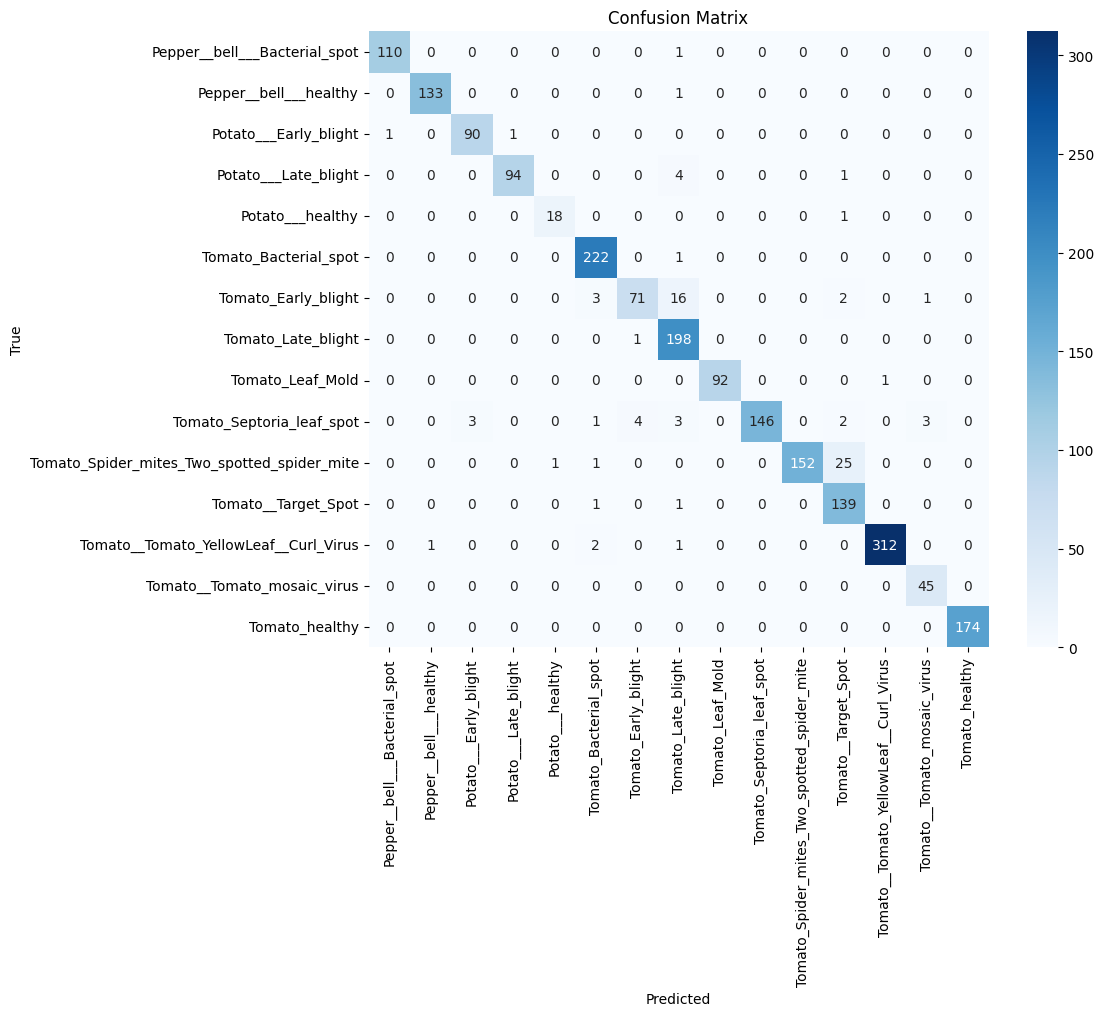

In [23]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Epoch [1/10], Loss D: 0.0247, Loss G: 4.6956
Epoch [2/10], Loss D: 0.0085, Loss G: 6.5541
Epoch [3/10], Loss D: 0.0042, Loss G: 6.6066
Epoch [4/10], Loss D: 0.0019, Loss G: 7.5594
Epoch [5/10], Loss D: 0.0018, Loss G: 7.6983


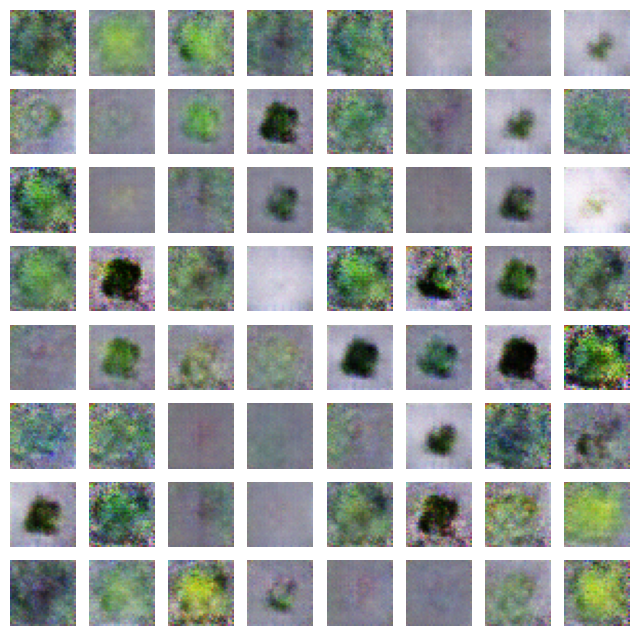

Epoch [6/10], Loss D: 0.0008, Loss G: 8.4319
Epoch [7/10], Loss D: 0.0057, Loss G: 7.1811
Epoch [8/10], Loss D: 0.0011, Loss G: 7.9277
Epoch [9/10], Loss D: 0.0001, Loss G: 10.5960
Epoch [10/10], Loss D: 0.0006, Loss G: 9.0212


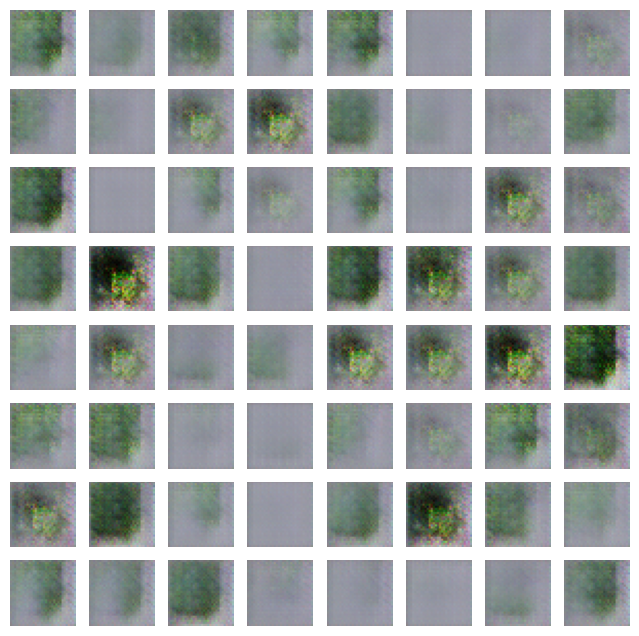

In [33]:
# Initialize the models
generator = Generator(z_dim, img_channels).to(device)
discriminator = Discriminator(img_channels).to(device)

optimizer_g = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

criterion = nn.BCELoss()

# Training the DCGAN
fixed_noise = torch.randn(64, z_dim, 1, 1).to(device)  # To monitor progress during training

for epoch in range(epochs):
    for i, (real_images, _) in enumerate(dataloader):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        labels_real = torch.ones(batch_size, 1).to(device)
        labels_fake = torch.zeros(batch_size, 1).to(device)

        # Train the Discriminator
        optimizer_d.zero_grad()
        outputs_real = discriminator(real_images)
        # print(outputs_real.shape)
        outputs_real = outputs_real.view(batch_size, -1)  # Flatten to shape [batch_size, 16]
        outputs_real = outputs_real.mean(dim=1).view(-1, 1)
        loss_real = criterion(outputs_real, labels_real)
        
        noise = torch.randn(batch_size, z_dim, 1, 1).to(device)
        fake_images = generator(noise)
        outputs_fake = discriminator(fake_images.detach())
        outputs_fake = outputs_fake.view(batch_size, -1)  # Flatten to shape [batch_size, 4]
        outputs_fake = outputs_fake.mean(dim=1).view(-1, 1)
        loss_fake = criterion(outputs_fake, labels_fake)

        loss_d = loss_real + loss_fake
        loss_d.backward()
        optimizer_d.step()

        # Train the Generator
        optimizer_g.zero_grad()
        outputs_fake = discriminator(fake_images)
        outputs_fake = outputs_fake.view(batch_size, -1)
        outputs_fake = outputs_fake.mean(dim=1).view(-1, 1)

        loss_g = criterion(outputs_fake, labels_real)
        loss_g.backward()
        optimizer_g.step()

    # Print the progress
    print(f"Epoch [{epoch+1}/{epochs}], Loss D: {loss_d.item():.4f}, Loss G: {loss_g.item():.4f}")

    # Save generated images periodically
    if (epoch + 1) % 5 == 0:
        with torch.no_grad():
            fake_images = generator(fixed_noise)
            fake_images = fake_images.detach().cpu().numpy()
            fake_images = (fake_images + 1) / 2  # Rescale to [0, 1]
            fig, ax = plt.subplots(figsize=(8, 8), nrows=8, ncols=8)
            for i in range(8):
                for j in range(8):
                    ax[i, j].imshow(np.transpose(fake_images[i * 8 + j], (1, 2, 0)))
                    ax[i, j].axis('off')
            plt.show()

torch.save(generator.state_dict(), 'trained_dcgan_generator.pth')

In [35]:
# Load the trained generator
generator = Generator(z_dim=100, img_channels=3).to(device)
generator.load_state_dict(torch.load('trained_dcgan_generator.pth'))
generator.eval()

/tmp/ipykernel_23/74594762.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load('trained_dcgan_generator.pth'))


Generator(
  (gen): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)

In [36]:
# Generate synthetic images for each class
num_synthetic_images = 100 
latent_dim = 100

synthetic_images = []
synthetic_labels = []

for class_idx in range(len(dataset.classes)):
    class_name = dataset.classes[class_idx]
    class_count = class_counts.get(class_name, 0)
    
    if class_count < 400:
        for _ in range(num_synthetic_images):
            noise = torch.randn(1, latent_dim, 1, 1).to(device)
            with torch.no_grad():
                fake_image = generator(noise)  # Generate fake image
                synthetic_images.append(fake_image.cpu())  # Store the generated image
                synthetic_labels.append(class_idx)  # Assign the class label


In [51]:
noise = torch.randn(1, latent_dim, 1, 1).to(device)
with torch.no_grad():
    fake_image = generator(noise)
    print(fake_image.shape)  # Verify the shape of generated images


torch.Size([1, 3, 32, 32])


In [46]:
class AugmentedDataset(Dataset):
    def __init__(self, original_dataset, synthetic_images, synthetic_labels, transform=None):
        self.original_dataset = original_dataset
        self.synthetic_images = synthetic_images
        self.synthetic_labels = synthetic_labels
        self.transform = transform

        self.classes = original_dataset.classes
        self.class_to_idx = original_dataset.class_to_idx

    def __len__(self):
        return len(self.original_dataset) + len(self.synthetic_images)

    def __getitem__(self, idx):
        if idx < len(self.original_dataset):
            image, label = self.original_dataset[idx]
        else:
            idx = idx - len(self.original_dataset)
            image = self.synthetic_images[idx]
            label = self.synthetic_labels[idx]

        if self.transform:
            if isinstance(image, torch.Tensor):
                image = image
            else:
                image = self.transform(image)
        
        return image, label


# augmented dataset
augmented_dataset = AugmentedDataset(
    original_dataset=dataset,
    synthetic_images=synthetic_images,
    synthetic_labels=synthetic_labels,
    transform=transform
)

augmented_train_loader = DataLoader(augmented_dataset, batch_size=32, shuffle=True)

In [60]:
augmented_class_counts = {cls: 0 for cls in all_classes}

# Iterate over augmented dataset to count samples in each class
for _, label in augmented_dataset:
    class_name = augmented_dataset.classes[label]
    if class_name in all_classes:
        augmented_class_counts[class_name] += 1

print("\nAugmented Dataset Summary:")
for class_name, count in augmented_class_counts.items():
    print(f"Class '{class_name}': {count} images")



Augmented Dataset Summary:
Class 'Pepper__bell___Bacterial_spot': 1097 images
Class 'Pepper__bell___healthy': 1578 images
Class 'Potato___Early_blight': 1100 images
Class 'Potato___Late_blight': 1100 images
Class 'Potato___healthy': 252 images
Class 'Tomato_Bacterial_spot': 2227 images
Class 'Tomato_Early_blight': 1100 images
Class 'Tomato_Late_blight': 2009 images
Class 'Tomato_Leaf_Mold': 1052 images
Class 'Tomato_Septoria_leaf_spot': 1871 images
Class 'Tomato_Spider_mites_Two_spotted_spider_mite': 1776 images
Class 'Tomato__Target_Spot': 1504 images
Class 'Tomato__Tomato_YellowLeaf__Curl_Virus': 3308 images
Class 'Tomato__Tomato_mosaic_virus': 473 images
Class 'Tomato_healthy': 1691 images
